# GA vs DE vs PSO 
This notebook implements from scratch a real-coded **GA** (SBX + polynomial mutation), **DE** (`DE/x/y/bin`), and **PSO** (inertia+topology).

It evaluates them on **Himmelblau, Griewank, Rastrigin, Rosenbrock** with 31 independent runs, success counts at \(10^{-6}\), descriptive statistics, Wilcoxon rank-sum tests, and plots.

## 0) Configuration: Run Mode and DOB-based Parameters
- `RUN_MODE`: `"quick"` (small budgets) or `"full"` (assignment-scale).
- `DOB`: set your date of birth as `"YYYY-MM-DD"`. Parameters are derived deterministically.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os
import time
from tqdm import tqdm

In [4]:
import os
os.makedirs("results_nb", exist_ok=True)
os.makedirs("figs", exist_ok=True)


## 1) Benchmark Problems

In [5]:
from math import sin, cos, sqrt, pi

def himmelblau(x):
    x1, x2 = x[0], x[1]
    t1 = (x1**2 + x2 - 11)**2
    t2 = (x1 + x2**2 - 7)**2
    return t1 + t2

def griewank(x):
    s = 0.0
    p = 1.0
    for i, xi in enumerate(x, start=1):
        s += (xi*xi) / 4000.0
        p *= cos(xi / sqrt(i))
    return s - p + 1.0

def rastrigin(x):
    A = 10.0
    n = len(x)
    return A*n + sum((xi*xi - A * cos(2*pi*xi)) for xi in x)

def rosenbrock(x):
    return sum(100.0*(x[i+1]-x[i]**2)**2 + (1-x[i])**2 for i in range(len(x)-1))

REGISTRY = {
    "Himmelblau2": (himmelblau, 2, [(-6, 6), (-6, 6)], 0.0, [3.0, 2.0]),
    "Griewank10": (griewank, 10, [(-600, 600)]*10, 0.0, [0.0]*10),
    "Rastrigin10": (rastrigin, 10, [(-5.12, 5.12)]*10, 0.0, [0.0]*10),
    "Rosenbrock10": (rosenbrock, 10, [(-5, 10)]*10, 0.0, [1.0]*10),
}
TOL = 1e-6
print("Problems:", list(REGISTRY.keys()))



Problems: ['Himmelblau2', 'Griewank10', 'Rastrigin10', 'Rosenbrock10']


## 2) DOB → Algorithm Parameters
Edit to match your Session 11 mapping if needed.

In [6]:
dob = '07-01-2000'  # dd-mm-yyyy
def choose_parameters_from_dob(dob):
    day = int(dob[0:2])
    month = int(dob[3:5])
    year = int(dob[6:10])

    if month <= 4:
        x = 'rand'
        inertia = 'linear-decrease'
    elif month <= 8:
        x = 'best'
        inertia = 'random'
    else:
        x = 'current-to-best'
        inertia = 'static'

    y = 2 if year % 2 == 0 else 1
    topology = 'ring' if year % 2 == 0 else 'star'
    seed_base = day

    # Derived configs
    de_strategy = f"DE/{x}/{y}"
    pso_topology = (topology, 2 if topology == 'ring' else None)
    if inertia == 'linear-decrease':
        pso_w_scheme = ('linear', 0.9, 0.4)
    elif inertia == 'random':
        pso_w_scheme = ('random', 0.4, 0.9)
    else:
        pso_w_scheme = ('constant', 0.729)

    ga_cfg = dict(pc=0.9, eta_c=15.0, eta_m=20.0, tournament_k=3)
    de_cfg = dict(F=0.5, CR=0.9, strategy=de_strategy)
    pso_cfg = dict(w_scheme=pso_w_scheme, topology=pso_topology, c1=1.49445, c2=1.49445)

    return dict(seed_base=seed_base, GA=ga_cfg, DE=de_cfg, PSO=pso_cfg)
choose_parameters_from_dob(dob)

{'seed_base': 7,
 'GA': {'pc': 0.9, 'eta_c': 15.0, 'eta_m': 20.0, 'tournament_k': 3},
 'DE': {'F': 0.5, 'CR': 0.9, 'strategy': 'DE/rand/2'},
 'PSO': {'w_scheme': ('linear', 0.9, 0.4),
  'topology': ('ring', 2),
  'c1': 1.49445,
  'c2': 1.49445}}

In [7]:
cfg = choose_parameters_from_dob(dob)
seed_base = cfg["seed_base"]
ga_cfg = cfg["GA"]
de_F = cfg["DE"]["F"]
de_CR = cfg["DE"]["CR"]
de_strategy = cfg["DE"]["strategy"]
pso_w_scheme = cfg["PSO"]["w_scheme"]
pso_topology = cfg["PSO"]["topology"]
pso_c1 = cfg["PSO"]["c1"]
pso_c2 = cfg["PSO"]["c2"]


In [8]:
def get_inertia(mode, w_max, w_min, iter, max_iter):
    if mode == "random":
        return w_min + random.random() * (w_max - w_min)
    elif mode == "linear-decrease":
        return w_max - ((w_max - w_min) * (iter / max_iter))
    elif mode == "constant":
        return 0.9
    else:
        raise ValueError(f"Unknown inertia mode: {mode}")


## 3) GA: SBX + Polynomial Mutation + Tournament + Elitism

In [9]:

import random
from math import pow

def sbx_crossover(p1, p2, bounds, eta_c=15.0, pc=1.0, rng=None):
    rng = rng or random
    n = len(p1)
    if rng.random() > pc:
        return p1[:], p2[:]
    c1, c2 = p1[:], p2[:]
    for i in range(n):
        x1, x2 = p1[i], p2[i]
        lo, hi = bounds[i]
        if abs(x1 - x2) < 1e-14:
            c1[i], c2[i] = x1, x2
            continue
        if x1 > x2:
            x1, x2 = x2, x1
        u = rng.random()
        beta = 1.0 + 2.0 * (x1 - lo) / (x2 - x1)
        alpha = 2.0 - pow(beta, -(eta_c+1.0))
        if u <= 1.0/alpha:
            betaq = pow(u * alpha, 1.0/(eta_c+1.0))
        else:
            betaq = pow(1.0/(2.0 - u*alpha), 1.0/(eta_c+1.0))
        c1_i = 0.5*((x1 + x2) - betaq*(x2 - x1))
        beta = 1.0 + 2.0 * (hi - x2) / (x2 - x1)
        alpha = 2.0 - pow(beta, -(eta_c+1.0))
        if u <= 1.0/alpha:
            betaq = pow(u * alpha, 1.0/(eta_c+1.0))
        else:
            betaq = pow(1.0/(2.0 - u*alpha), 1.0/(eta_c+1.0))
        c2_i = 0.5*((x1 + x2) + betaq*(x2 - x1))
        c1[i] = min(max(c1_i, lo), hi)
        c2[i] = min(max(c2_i, lo), hi)
    return c1, c2

def polynomial_mutation(x, bounds, eta_m=20.0, pm=None, rng=None):
    rng = rng or random
    n = len(x)
    if pm is None:
        pm = 1.0 / n
    y = x[:]
    for i in range(n):
        if rng.random() > pm:
            continue
        lo, hi = bounds[i]
        if hi - lo <= 0:
            continue
        xi = y[i]
        delta1 = (xi - lo) / (hi - lo)
        delta2 = (hi - xi) / (hi - lo)
        u = rng.random()
        mut_pow = 1.0 / (eta_m + 1.0)
        if u < 0.5:
            xy = 1.0 - delta1
            val = 2*u + (1 - 2*u) * pow(xy, (eta_m + 1.0))
            deltaq = pow(val, mut_pow) - 1.0
        else:
            xy = 1.0 - delta2
            val = 2*(1 - u) + 2*(u - 0.5) * pow(xy, (eta_m + 1.0))
            deltaq = 1.0 - pow(val, mut_pow)
        xi = xi + deltaq * (hi - lo)
        y[i] = min(max(xi, lo), hi)
    return y

class GeneticAlgorithm:
    def __init__(self, fitness, bounds, pop_size=50, generations=1000, 
                 pc=0.9, pm=None, eta_c=15.0, eta_m=20.0, tournament_k=3, elite_fraction=0.02, seed=None):
        self.fitness = fitness
        self.bounds = bounds
        self.n = len(bounds)
        self.pop_size = pop_size
        self.generations = generations
        self.pc = pc
        self.pm = pm if pm is not None else 1.0/self.n
        self.eta_c = eta_c
        self.eta_m = eta_m
        self.tournament_k = tournament_k
        self.elite = max(1, int(elite_fraction * pop_size))
        self.rng = random.Random(seed)

    def _random_individual(self):
        return [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds]

    def _tournament(self, pop, fits):
        k = self.tournament_k
        idxs = [self.rng.randrange(len(pop)) for _ in range(k)]
        best = min(idxs, key=lambda i: fits[i])
        return pop[best][:]

    def run(self, return_history=False):
        pop = [self._random_individual() for _ in range(self.pop_size)]
        fits = [self.fitness(ind) for ind in pop]
        best = min(zip(pop, fits), key=lambda t: t[1])
        hist = [best[1]]
        for _ in range(self.generations):
            elite_idx = sorted(range(len(pop)), key=lambda i: fits[i])[:self.elite]
            new_pop = [pop[i][:] for i in elite_idx]
            while len(new_pop) < self.pop_size:
                p1 = self._tournament(pop, fits)
                p2 = self._tournament(pop, fits)
                c1, c2 = sbx_crossover(p1, p2, self.bounds, eta_c=self.eta_c, pc=self.pc, rng=self.rng)
                c1 = polynomial_mutation(c1, self.bounds, eta_m=self.eta_m, pm=self.pm, rng=self.rng)
                if len(new_pop) < self.pop_size:
                    new_pop.append(c1)
                if len(new_pop) < self.pop_size:
                    c2 = polynomial_mutation(c2, self.bounds, eta_m=self.eta_m, pm=self.pm, rng=self.rng)
                    new_pop.append(c2)
            pop = new_pop
            fits = [self.fitness(ind) for ind in pop]
            cand = min(zip(pop, fits), key=lambda t: t[1])
            if cand[1] < best[1]:
                best = cand
            hist.append(best[1])
        if return_history:
            return best, hist
        return best


## 4) Differential Evolution (`DE/x/y/bin`)

In [10]:
import random

class DifferentialEvolution:
    def __init__(self, fitness, bounds, pop_size=50, generations=1000, F=0.5, CR=0.9,
                 strategy="DE/rand/1/bin", seed=None):
        self.fitness = fitness
        self.bounds = bounds
        self.n = len(bounds)
        self.pop_size = pop_size
        self.generations = generations
        self.F = F
        self.CR = CR
        self.strategy = strategy
        self.rng = random.Random(seed)

    def _random_vector(self):
        return [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds]

    def _ensure_bounds(self, v):
        out = []
        for (val, (lo, hi)) in zip(v, self.bounds):
            if val < lo or val > hi:
                if val < lo: val = lo + (lo - val)
                if val > hi: val = hi - (val - hi)
            out.append(min(max(val, lo), hi))
        return out

    def _mutate(self, pop, idx, best_idx=None):
        idxs = [i for i in range(self.pop_size) if i != idx]
        a, b, c, d, e = self.rng.sample(idxs, 5)
        x = pop[idx]
        xb = pop[best_idx] if best_idx is not None else None
        F = self.F
        strat = self.strategy.replace("/bin","")
        if strat == "DE/rand/1":
            v = [pop[a][i] + F*(pop[b][i] - pop[c][i]) for i in range(self.n)]
        elif strat == "DE/best/1":
            v = [xb[i] + F*(pop[a][i] - pop[b][i]) for i in range(self.n)]
        elif strat == "DE/rand/2":
            v = [pop[a][i] + F*(pop[b][i] - pop[c][i]) + F*(pop[d][i] - pop[e][i]) for i in range(self.n)]
        elif strat == "DE/best/2":
            v = [xb[i] + F*(pop[a][i] - pop[b][i]) + F*(pop[c][i] - pop[d][i]) for i in range(self.n)]
        elif strat == "DE/current-to-best/1":
            v = [x[i] + F*(xb[i] - x[i]) + F*(pop[a][i] - pop[b][i]) for i in range(self.n)]
        else:
            raise ValueError("Unknown strategy")
        return self._ensure_bounds(v)

    def _crossover_bin(self, target, donor):
        n = self.n
        u = target[:]
        j_rand = self.rng.randrange(n)
        for j in range(n):
            if self.rng.random() <= self.CR or j == j_rand:
                u[j] = donor[j]
        return u

    def run(self, return_history=False):
        pop = [self._random_vector() for _ in range(self.pop_size)]
        fits = [self.fitness(ind) for ind in pop]
        best_idx = min(range(self.pop_size), key=lambda i: fits[i])
        best = (pop[best_idx][:], fits[best_idx])
        hist = [best[1]]
        use_best = any(k in self.strategy for k in ["best","current-to-best"])
        for _ in range(self.generations):
            for i in range(self.pop_size):
                donor = self._mutate(pop, i, best_idx=best_idx if use_best else None)
                trial = self._crossover_bin(pop[i], donor)
                f_trial = self.fitness(trial)
                if f_trial <= fits[i]:
                    pop[i] = trial
                    fits[i] = f_trial
                    if f_trial < best[1]:
                        best = (trial[:], f_trial)
                        best_idx = i
            hist.append(best[1])
        if return_history:
            return best, hist
        return best



## 5) PSO (Inertia + Topology)

In [11]:
import random

class ParticleSwarmOptimization:
    def __init__(self, fitness, bounds, swarm_size=40, iterations=1000,
                 w_scheme=("constant", 0.729), c1=1.49445, c2=1.49445,
                 topology=("global", None), vmax_frac=0.2, seed=None):
        self.fitness = fitness
        self.bounds = bounds
        self.n = len(bounds)
        self.swarm_size = swarm_size
        self.iterations = iterations
        self.w_scheme = w_scheme   # ("constant", w) | ("linear", w0, wT) | ("random", wmin, wmax)
        self.c1 = c1
        self.c2 = c2
        self.topology = topology   # ("global", None) or ("ring", k)
        self.vmax = [vmax_frac*(hi - lo) for (lo, hi) in bounds]
        self.rng = random.Random(seed)

    def _init_particle(self):
        x = [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds]
        v = [self.rng.uniform(-vm, vm) for vm in self.vmax]
        return x, v, x[:], None

    def _neighbors(self, idx):
        topo, k = self.topology
        if topo == "global":
            return range(self.swarm_size)
        elif topo == "ring":
            k = int(k) if k else 2
            return [ (idx + d) % self.swarm_size for d in range(-k, k+1) ]
        else:
            raise ValueError("Unknown topology")

    def _w(self, t, T):
        scheme = self.w_scheme[0]
        if scheme == "constant":
            return float(self.w_scheme[1])
        elif scheme == "linear":
            w0, wT = float(self.w_scheme[1]), float(self.w_scheme[2])
            return w0 + (wT - w0) * (t / max(1, T-1))
        elif scheme == "random":
            wmin, wmax = float(self.w_scheme[1]), float(self.w_scheme[2])
            return self.rng.uniform(wmin, wmax)
        else:
            raise ValueError("Unknown inertia scheme")

    def run(self, return_history=False):
        swarm = [self._init_particle() for _ in range(self.swarm_size)]
        for i in range(self.swarm_size):
            x, v, pbest, f = swarm[i]
            fval = self.fitness(x)
            swarm[i] = (x, v, x[:], fval)

        best_idx = min(range(self.swarm_size), key=lambda i: swarm[i][3])
        gbest = (swarm[best_idx][2][:], swarm[best_idx][3])
        hist = [gbest[1]]

        for t in range(self.iterations):
            w = self._w(t, self.iterations)
            for i in range(self.swarm_size):
                x, v, pbest, f_pbest = swarm[i]
                neigh = list(self._neighbors(i))
                g = min(neigh, key=lambda j: swarm[j][3])
                gbest_local = (swarm[g][2][:], swarm[g][3])

                new_v = []
                for d in range(self.n):
                    r1 = self.rng.random()
                    r2 = self.rng.random()
                    vd = (w * v[d] 
                          + self.c1 * r1 * (pbest[d] - x[d]) 
                          + self.c2 * r2 * (gbest_local[0][d] - x[d]))
                    vm = self.vmax[d]
                    if vd > vm: vd = vm
                    if vd < -vm: vd = -vm
                    new_v.append(vd)

                new_x = []
                for d in range(self.n):
                    nd = x[d] + new_v[d]
                    lo, hi = self.bounds[d]
                    if nd < lo:
                        nd = lo + (lo - nd); new_v[d] = -new_v[d]
                    if nd > hi:
                        nd = hi - (nd - hi); new_v[d] = -new_v[d]
                    if nd < lo: nd = lo
                    if nd > hi: nd = hi
                    new_x.append(nd)

                fval = self.fitness(new_x)
                if fval <= f_pbest:
                    swarm[i] = (new_x, new_v, new_x[:], fval)
                else:
                    swarm[i] = (new_x, new_v, pbest, f_pbest)

            best_idx = min(range(self.swarm_size), key=lambda i: swarm[i][3])
            gbest = (swarm[best_idx][2][:], swarm[best_idx][3])
            hist.append(gbest[1])

        if return_history:
            return gbest, hist
        return gbest


## 6) Wilcoxon Rank-Sum (Mann–Whitney U)

In [12]:
from math import sqrt, erf
from collections import Counter

def _rankdata(a):
    sorted_idx = sorted(range(len(a)), key=lambda i: a[i])
    ranks = [0]*len(a)
    i = 0; r = 1
    while i < len(a):
        j = i
        while j+1 < len(a) and a[sorted_idx[j+1]] == a[sorted_idx[i]]:
            j += 1
        avg_rank = (r + r + (j - i)) / 2.0
        for k in range(i, j+1):
            ranks[sorted_idx[k]] = avg_rank
        r += (j - i + 1)
        i = j + 1
    return ranks

def mann_whitney_u(x, y):
    n1, n2 = len(x), len(y)
    combined = x + y
    ranks = _rankdata(combined)
    R1 = sum(ranks[:n1])
    U1 = R1 - n1*(n1+1)/2.0
    U2 = n1*n2 - U1
    U = min(U1, U2)
    counts = Counter(combined)
    tie_sum = sum((t**3 - t) for t in counts.values())
    tie_corr = 1.0 - tie_sum / ((n1+n2)**3 - (n1+n2)) if (n1+n2) > 1 else 1.0
    mu = n1*n2/2.0
    sigma = (tie_corr * n1*n2*(n1+n2+1)/12.0) ** 0.5
    if sigma == 0.0:
        return U, 1.0
    z = (U - mu) / sigma
    Phi = lambda z: 0.5*(1.0 + erf(z / (2**0.5)))
    p = 2.0 * (1.0 - Phi(abs(z)))
    return U, p


## 7) Experimental Design & Plot Helpers

In [13]:
import os, random, statistics
import matplotlib.pyplot as plt

def budgets(run_mode):
    if run_mode == "quick":
        return {
            "Himmelblau2": dict(GA=dict(pop=30, gen=80),  DE=dict(pop=30, gen=80),  PSO=dict(swarm=30, it=80)),
            "Griewank10":  dict(GA=dict(pop=40, gen=120), DE=dict(pop=40, gen=120), PSO=dict(swarm=40, it=120)),
            "Rastrigin10": dict(GA=dict(pop=40, gen=160), DE=dict(pop=40, gen=160), PSO=dict(swarm=40, it=160)),
            "Rosenbrock10":dict(GA=dict(pop=50, gen=200), DE=dict(pop=50, gen=200), PSO=dict(swarm=50, it=200)),
        }
    else:
        return {
            "Himmelblau2": dict(GA=dict(pop=60, gen=400), DE=dict(pop=60, gen=400), PSO=dict(swarm=60, it=400)),
            "Griewank10":  dict(GA=dict(pop=80, gen=800), DE=dict(pop=80, gen=800), PSO=dict(swarm=80, it=800)),
            "Rastrigin10": dict(GA=dict(pop=80, gen=1200),DE=dict(pop=80, gen=1200),PSO=dict(swarm=80, it=1200)),
            "Rosenbrock10":dict(GA=dict(pop=100,gen=1500),DE=dict(pop=100,gen=1500),PSO=dict(swarm=100,it=1500)),
        }

RUNS = 31

def boxplot_best_values(table, title, outpath):
    keys = list(table.keys())
    data = [table[k] for k in keys]
    plt.figure()
    plt.boxplot(data, labels=keys, showmeans=True)
    plt.yscale("log")
    plt.title(title)
    plt.ylabel("Final best value (log scale)")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def plot_convergence(median_histories, title, outpath):
    plt.figure()
    for k, hist in median_histories.items():
        plt.plot(hist, label=k)
    plt.yscale("log")
    plt.xlabel("Iteration / Generation")
    plt.ylabel("Median of best-so-far (log)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()



## 8) Run the Experiments

In [15]:
import hashlib
import pandas as pd
import os
import numpy as np
import time
run_mode = "full"   # "quick" or "full"
bud = budgets(run_mode)
all_histories = {}
os.makedirs("results_nb", exist_ok=True)

for problem_key, (fitness, dim, bounds, opt_val, opt_x) in REGISTRY.items():
    for algo in ["GA", "DE", "PSO"]:
        combo_key = f"{problem_key}_{algo}"
        combo_rows = []
        combo_histories = []

        b = bud[problem_key][algo]
        for run in range(RUNS):
            # Deterministic seed from DOB + problem + algo + run
            s = f"{seed_base}_{problem_key}_{algo}_{run}"
            seed = int(hashlib.sha256(s.encode()).hexdigest(), 16) % (2**31)

            # --- Initialize optimizer ---
            if algo == "GA":
                optimizer = GeneticAlgorithm(
                    fitness=fitness,
                    bounds=bounds,
                    pop_size=int(b["pop"]),
                    generations=int(b["gen"]),
                    pc=ga_cfg["pc"],
                    eta_c=ga_cfg["eta_c"],
                    eta_m=ga_cfg["eta_m"],
                    tournament_k=ga_cfg["tournament_k"],
                    seed=seed
                )

            elif algo == "DE":
                optimizer = DifferentialEvolution(
                    fitness=fitness,
                    bounds=bounds,
                    pop_size=int(b["pop"]),
                    generations=int(b["gen"]),
                    F=de_F,
                    CR=de_CR,
                    strategy=de_strategy + "/bin",
                    seed=seed
                )

            elif algo == "PSO":
                optimizer = ParticleSwarmOptimization(
                    fitness=fitness,
                    bounds=bounds,
                    swarm_size=int(b["swarm"]),
                    iterations=int(b["it"]),
                    w_scheme=pso_w_scheme,
                    topology=pso_topology,
                    c1=pso_c1,
                    c2=pso_c2,
                    seed=seed
                )

            # --- Run optimizer with timing ---
            t0 = time.time()
            best, history = optimizer.run(return_history=True)
            time_elapsed = time.time() - t0

            x_best, f_best = best
            success_at_1e_6 = int(f_best <= 1e-6)

            # Flatten x_best to string
            x_best_str = ",".join(map(str, np.round(x_best, 6)))

            combo_rows.append({
                "problem": problem_key,
                "algo": algo,
                "run": run,
                "seed": seed,
                "f_best": float(f_best),
                "success_at_1e-6": success_at_1e_6,
                "x_best": x_best_str,
                "time_elapsed": time_elapsed
            })
            combo_histories.append(history)

        df_combo = pd.DataFrame(combo_rows)
        df_combo.to_csv(os.path.join("results_nb", f"{combo_key}.csv"), index=False)
        all_histories[combo_key] = combo_histories

print(" Master loop completed. CSVs written to results_nb")


 Master loop completed. CSVs written to results_nb


In [16]:
# Produce per-problem summaries and save to results_nb/summary_{problem}.csv
import os
import pandas as pd

for problem_key in REGISTRY.keys():
    rows = []
    for algo in ("GA", "DE", "PSO"):
        path = os.path.join("results_nb", f"{problem_key}_{algo}.csv")
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        fcol = df["f_best"]
        mean_f = float(fcol.mean())
        median_f = float(fcol.median())
        stdev_f = float(fcol.std(ddof=1)) if len(fcol) > 1 else float("nan")
        min_f = float(fcol.min())
        max_f = float(fcol.max())
        successes = int(df["success_at_1e-6"].sum())
        rows.append({
            "problem": problem_key,
            "algo": algo,
            "mean_f": mean_f,
            "median_f": median_f,
            "stdev_f": stdev_f,
            "min_f": min_f,
            "max_f": max_f,
            "successes_<=1e-6": successes,
            "runs": RUNS
        })

    if not rows:
        continue

    summary_df = pd.DataFrame(rows, columns=[
        "problem", "algo", "mean_f", "median_f", "stdev_f",
        "min_f", "max_f", "successes_<=1e-6", "runs"
    ])
    summary_df = summary_df.sort_values("median_f").reset_index(drop=True)
    outpath = os.path.join("results_nb", f"summary_{problem_key}.csv")
    summary_df.to_csv(outpath, index=False)


## 9) Inspect Results

In [17]:
# Pairwise Wilcoxon summary (write results_nb/pairwise_wilcoxon_summary.csv)
import os
import pandas as pd

pairwise_path = os.path.join("results_nb", "pairwise_wilcoxon_summary.csv")
pairs = [("GA", "DE"), ("GA", "PSO"), ("DE", "PSO")]
rows = []

for problem_key in REGISTRY.keys():
    for a, b in pairs:
        path_a = os.path.join("results_nb", f"{problem_key}_{a}.csv")
        path_b = os.path.join("results_nb", f"{problem_key}_{b}.csv")
        if not (os.path.exists(path_a) and os.path.exists(path_b)):
            continue
        df_a = pd.read_csv(path_a)
        df_b = pd.read_csv(path_b)
        if "f_best" not in df_a.columns or "f_best" not in df_b.columns:
            continue
        x = df_a["f_best"].astype(float).tolist()
        y = df_b["f_best"].astype(float).tolist()
        if len(x) == 0 or len(y) == 0:
            continue
        U, p = mann_whitney_u(x, y)
        rows.append({
            "problem": problem_key,
            "algo_A": a,
            "algo_B": b,
            "U": float(U),
            "p_value": float(p)
        })

if rows:
    pairwise_df = pd.DataFrame(rows, columns=["problem", "algo_A", "algo_B", "U", "p_value"])
    pairwise_df.to_csv(pairwise_path, index=False)
else:
    print("No pairwise comparisons were produced (missing per-algo CSVs).")


In [18]:
import os, glob, pandas as pd

pairwise_path = os.path.join("results_nb", "pairwise_wilcoxon_summary.csv")

def load_combo_csvs():
    paths = sorted(glob.glob(os.path.join("results_nb", "*.csv")))
    frames = []
    for p in paths:
        name = os.path.basename(p)
        if name == "pairwise_wilcoxon_summary.csv":
            continue
        if name.startswith("summary_"):
            continue
        df = pd.read_csv(p)
        df["combo"] = name.replace(".csv", "")
        frames.append(df)
    if not frames:
        return None
    return pd.concat(frames, ignore_index=True)

pairwise = pd.read_csv(pairwise_path) if os.path.exists(pairwise_path) else None
runs_df = load_combo_csvs()


## 9) Visualization of optimizer behavior
Compares GA, DE, and PSO across benchmark problems using the stored CSV results.

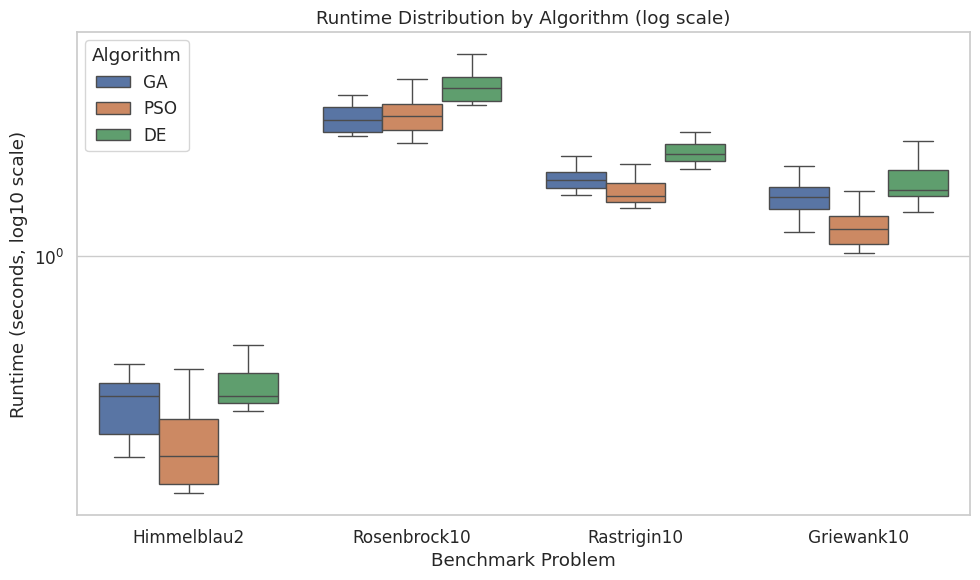

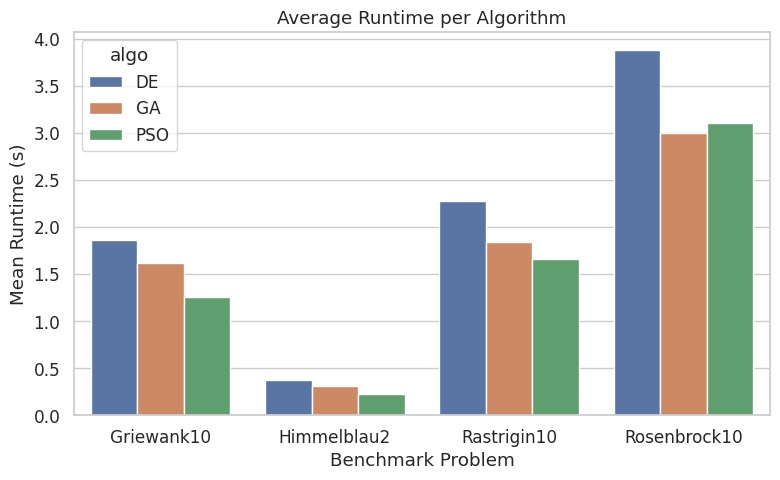

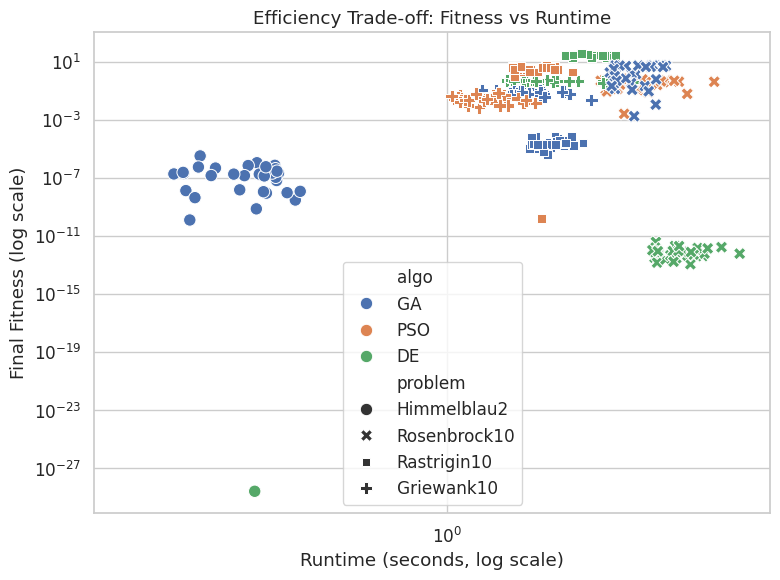

In [19]:
# %% [markdown]
# ## 10) Runtime Analysis and Visualization

# %%
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob

sns.set_theme(style="whitegrid", font_scale=1.1)

results_dir = "results_nb"
csv_files = glob(os.path.join(results_dir, "*.csv"))

dfs = [pd.read_csv(f) for f in csv_files]
df_all = pd.concat(dfs, ignore_index=True)

# Ensure numeric
df_all["time_elapsed"] = pd.to_numeric(df_all["time_elapsed"], errors="coerce")

# ---------------------------
# 1. Runtime Distribution
# ---------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_all,
    x="problem",
    y="time_elapsed",
    hue="algo",
    showfliers=False
)
plt.yscale("log")
plt.title("Runtime Distribution by Algorithm (log scale)")
plt.ylabel("Runtime (seconds, log10 scale)")
plt.xlabel("Benchmark Problem")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

# ---------------------------
# 2. Average Runtime Comparison
# ---------------------------
runtime_summary = (
    df_all.groupby(["problem", "algo"])["time_elapsed"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=runtime_summary,
    x="problem",
    y="time_elapsed",
    hue="algo"
)
plt.title("Average Runtime per Algorithm")
plt.ylabel("Mean Runtime (s)")
plt.xlabel("Benchmark Problem")
plt.tight_layout()
plt.show()

# ---------------------------
# 3. Fitness vs. Runtime (Efficiency Trade-off)
# ---------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all,
    x="time_elapsed",
    y="f_best",
    hue="algo",
    style="problem",
    s=80
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Runtime (seconds, log scale)")
plt.ylabel("Final Fitness (log scale)")
plt.title("Efficiency Trade-off: Fitness vs Runtime")
plt.tight_layout()
plt.show()


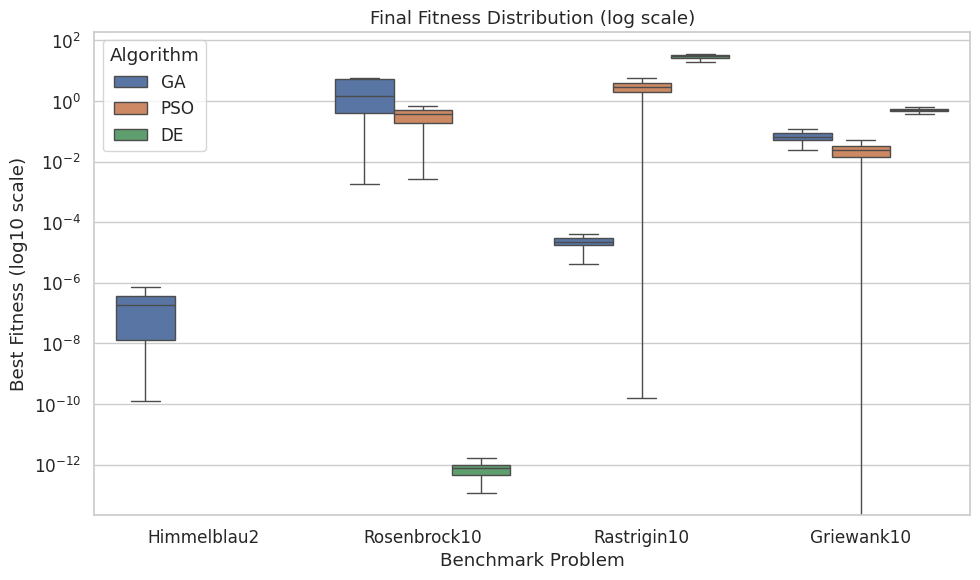

In [20]:

# ---------------------------
# 1. Boxplots of final fitness
# ---------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x="problem", y="f_best", hue="algo", showfliers=False)
plt.yscale("log")
plt.title("Final Fitness Distribution (log scale)")
plt.ylabel("Best Fitness (log10 scale)")
plt.xlabel("Benchmark Problem")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


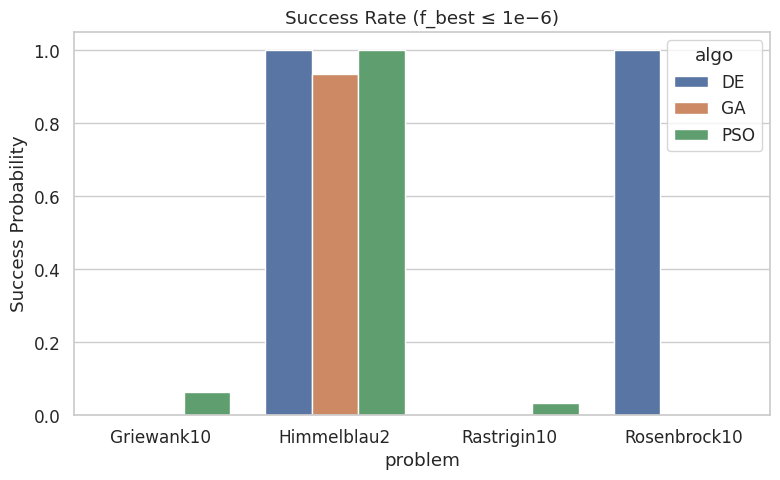

In [21]:
# ---------------------------
# 2. Success rate barplot
# ---------------------------
success_df = (
    df_all.groupby(["problem", "algo"])["success_at_1e-6"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.barplot(data=success_df, x="problem", y="success_at_1e-6", hue="algo")
plt.title("Success Rate (f_best ≤ 1e−6)")
plt.ylabel("Success Probability")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

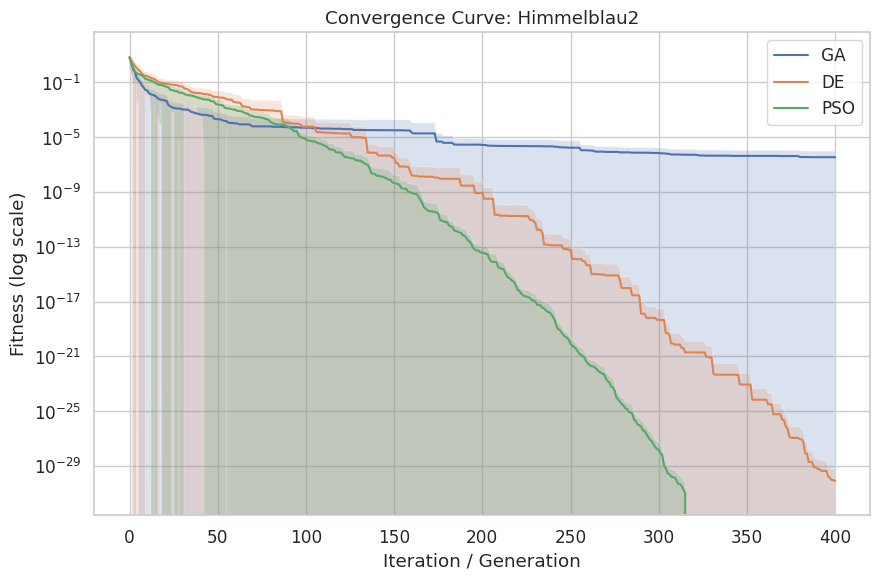

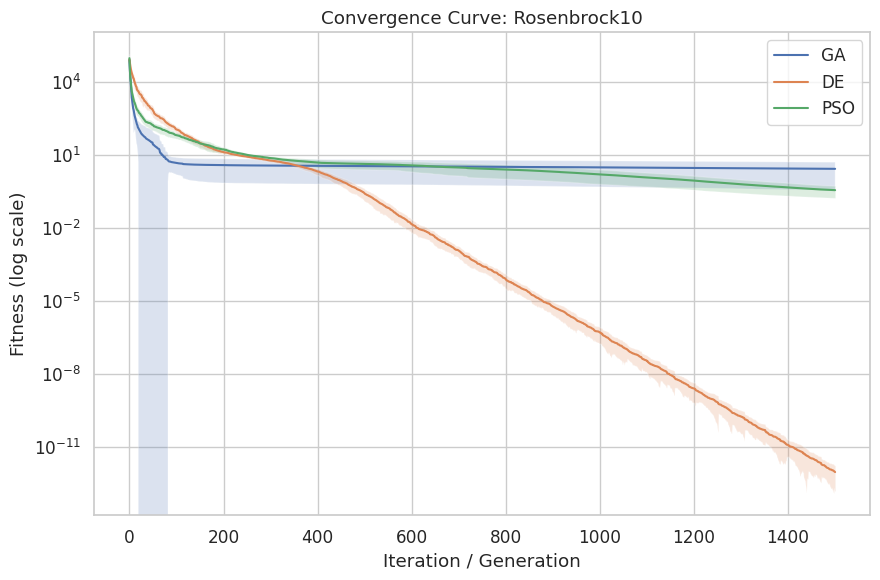

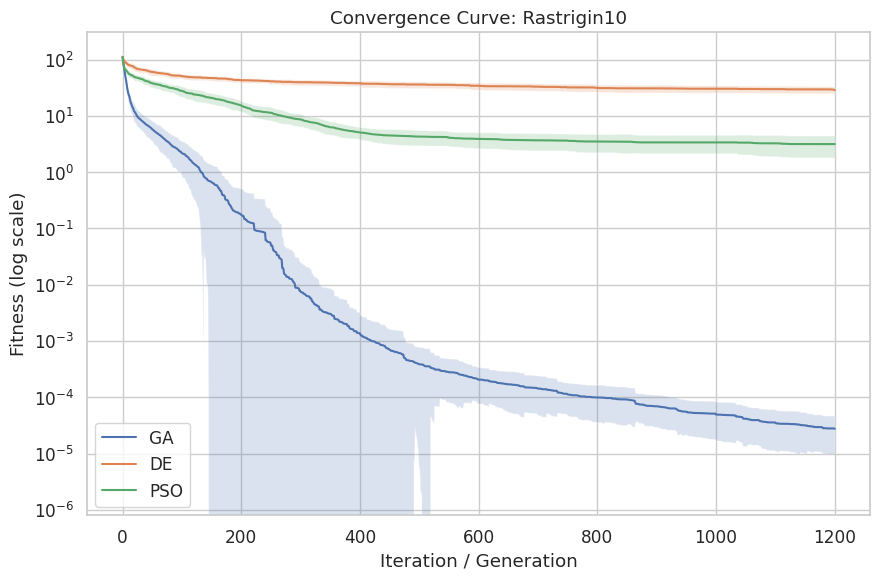

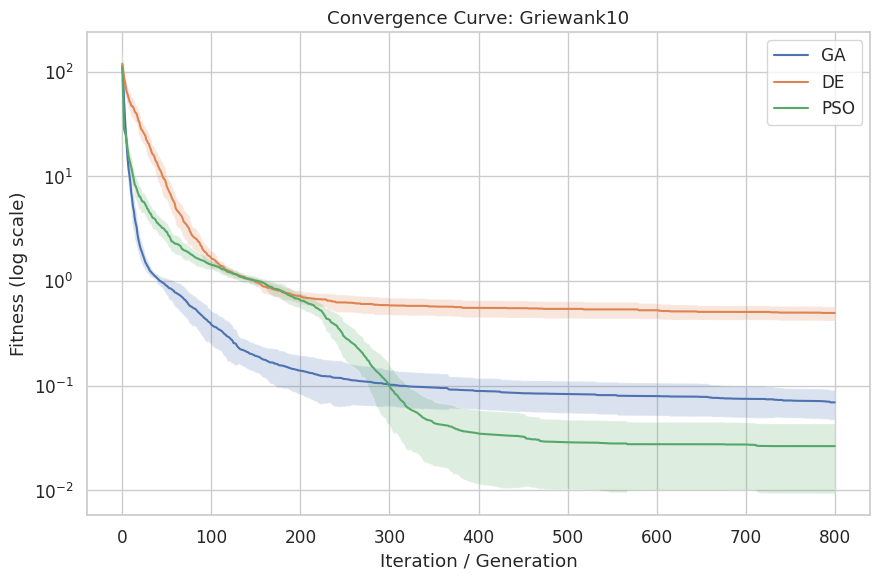

In [22]:

# ---------------------------
# 3. Convergence curves (mean ± std)
# ---------------------------
# This uses 'all_histories' saved in memory if still available; otherwise, reconstruct if you saved histories
if "all_histories" in globals():
    for problem_key in df_all["problem"].unique():
        plt.figure(figsize=(9, 6))
        for algo in ["GA", "DE", "PSO"]:
            combo_key = f"{problem_key}_{algo}"
            if combo_key not in all_histories:
                continue
            runs = all_histories[combo_key]
            max_len = max(len(h) for h in runs)
            arr = np.full((len(runs), max_len), np.nan)
            for i, h in enumerate(runs):
                arr[i, :len(h)] = h
            mean_curve = np.nanmean(arr, axis=0)
            std_curve = np.nanstd(arr, axis=0)
            x = np.arange(len(mean_curve))
            plt.plot(x, mean_curve, label=algo)
            plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
        plt.yscale("log")
        plt.title(f"Convergence Curve: {problem_key}")
        plt.xlabel("Iteration / Generation")
        plt.ylabel("Fitness (log scale)")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ 'all_histories' not found in memory. Convergence plots skipped. Rerun main loop in same session to include them.")


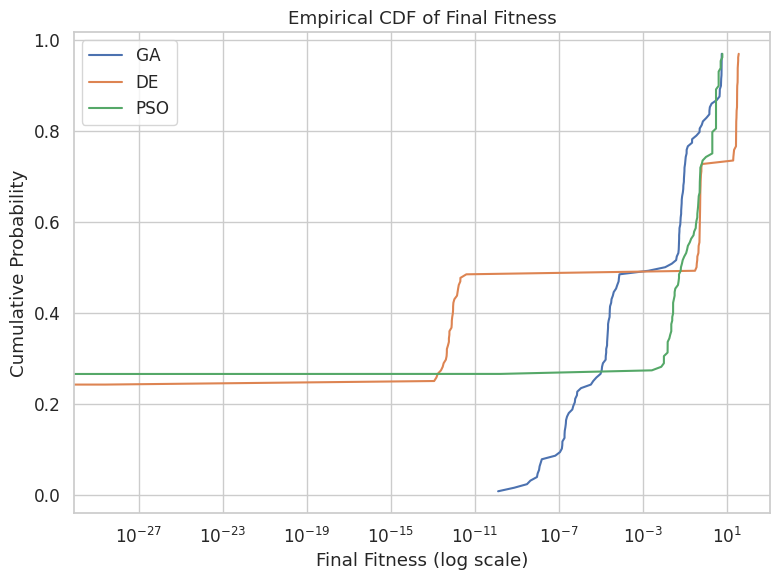

In [23]:
# ---------------------------
# 4. ECDF of final fitness
# ---------------------------
plt.figure(figsize=(8, 6))
for algo in ["GA", "DE", "PSO"]:
    fvals = df_all.loc[df_all["algo"] == algo, "f_best"].values
    fvals = np.sort(fvals)
    ecdf = np.arange(1, len(fvals) + 1) / len(fvals)
    plt.plot(fvals, ecdf, label=algo)
plt.xscale("log")
plt.title("Empirical CDF of Final Fitness")
plt.xlabel("Final Fitness (log scale)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.tight_layout()
plt.show()
